In [3]:
%matplotlib inline
import numpy as np
import pylab as pl
import sympy as sym
from sympy.functions import Abs
#from sympy import Abs, Symbol, S

## Goals of today:

- Check how good or bad are the estimates given in the theoretical lecture
- Compare Equispaced with Chebyshev
- Compute errors, plot error tables
- Implement Bernstein interpolation
- Compare Bernstein interpolation with Lagrangian interpolation

## Lagrangian part

The estimate we want to check:

$$
|| f -p || \leq ||f^{n+1}||_\infty \frac{||w(x)||_\infty}{(n+1)!}
$$

in order to do so we need to define, simbolic and numerical functions. [`Sympy`]() is a very useful package to handle symbolic expressions and to export them to numerical functions. A the beginnnig of this notebook it is imported with the command: `import sympy as sym`. Let's define a simple function:

**Hint:** Try to play around, derivatives integrals...

In [13]:
x = np.linspace(-10, 10, 2**10 + 1)
t = sym.symbols('t')

#We can define a function in these two equivalent ways

def runge(x):
    return 1./(1. + x**2)

runge = lambda x:1. / (1 + x**2)

#We can now plot it

y = runge(x)
_ = pl.plot(x,y)

def l_infty(y):
    return abs(y).max()  # takes the abs of y values and then gets the max

l = np.linalg.norm(y, ord=np.inf)

print(l)

yy = np.random.rand(1000000)

print(len(yy))

l_infty = lambda y: np.linalg.norm(y, ord = np.inf)

l_infty(yy)

l_infty_0 = lambda y: abs(y).max()

def l_infty_1(y):
    m = -1.0
    for i in range(len(y)):
        m = max(m,abs(y[i]))
        
def l_infty_2(y):
    m = -1.0
    for i in y:
        m = max(m,abs(i)
        

%timeit l_infty(yy) 
%timeit l_infty_0(yy) # the numpy solution is the best: it using vectorized operations
%timeit l_infty_1(yy)
%timeit l_infty_2(yy)



SyntaxError: invalid syntax (<ipython-input-13-af8c2f43dd88>, line 46)

In [15]:
# Contruct a symbolic function...
t = sym.var('t')
fs = 1.0/(1.0+t**2)

fs.diff(t,1)

# This will no work...
fs(x)

TypeError: 'Mul' object is not callable

To make this function *digestible* by numpy we use the simple command `nf = sym.lambdify(t,f, 'numpy')`. This allows the function nf to be called with numpy arguments.

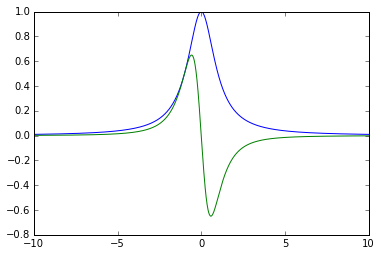

In [18]:
nf = sym.lambdify(t, fs, "numpy")
nfprime = sym.lambdify(t, fs.diff(t,1), 'numpy')

_=pl.plot(x,nf(x))
_=pl.plot(x,nfprime(x))

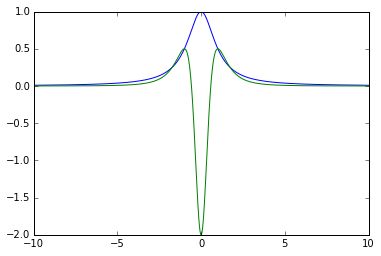

In [23]:
#def my_derivatives(f, n, t=t):
 #   return sym.lambdify(t,f.diff(t,n),'numpy')

my_derivatives = lambda f,n: sym.lambdify(t,f.diff(t,n), 'numpy')


fpp = my_derivatives(fs,2)

_=pl.plot(x,nf(x))
_=pl.plot(x,fpp(x))

In [27]:
# Check for two functions..

function_set = [fs, sym.sin(2*sym.pi*t)]

for my_f in function_set:
    print('**************')
    print my_f
    for i in range(5):
        print l_infty(my_derivatives(my_f,i)(x))


**************
1.0/(t**2 + 1.0)
1.0
0.649412355588
2.0
4.66644172318
24.0
**************
sin(2*pi*t)
1.0
6.28318530718
39.4784176044
248.050213442
1558.54545654


We aim at controlling all of the pieces of the inequality above, plot how terms behave with the degree, and see what happens `:)`

Good thing is to start from the beginning and control the term $||f-p||_\infty$. We recall that:
$$
p = \mathcal{L}^n f := \sum_{i=0}^n f(x_i) l^n_i(x),
$$

with

$$
l^n_i(x) := \prod_{j=0, j\neq i}^n \frac{(x-x_j)}{(x_i-x_j)}  \qquad
i = 0, \dots, n.
$$

Let's implment this guy. We want to fill the matrix `Ln` with $n+1$ rows and as many colums as the number of points where we evaluate the funtion. 

$$
\text{Ln}_{ij}:= l_i(x_j)
$$

so that

$$
\text{Ln}_{ij} f(q_i) = \sum_{i=0}^n l_i(x_j) f(q_i) 0 (\mathcal{L}^nf)(x_j)
$$

A good idea would be to collect the few operations in a function, like this one:
```python
def lagrangian_interpolation_matrix(x,q):
    ...
    return Ln
```
so that we can recall it whenever we need it.

**Hint:** I wouldn't call myself a good programmer, but I do my best to be like that. First construct the code in the main section of your program, run it, check that it works, then collect the precious commmands you wrote in an function.

### Step 0

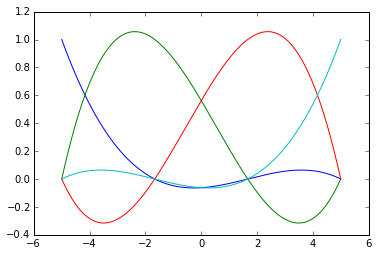

In [34]:
n = 3
q = np.linspace(-5,5,n+1)

Ln = np.zeros((n+1, len(x)))

for i in range(n+1):
    Ln[i] = np.ones_like(x)
    for j in range(n+1):
        if j!=i:
            Ln[i] *= (x - q[j])/(q[i]-q[j])
            
#Equivalently 

#Ln[i] = np.product([(x - q[j])/(q[i]-q[j]) for j in range(n+1) if j is not i], axis = 0)

_ = pl.plot(x, Ln.T)

## Step 1

Now we transform this into a function that takes the points where we want to compute the 
matrix, and the interpolation points we use to define the basis.

In [40]:
def lagrangian_interpolation_matrix(x,q):
    Ln = np.zeros((len(q), len(x)))

    for i in range(len(q)):
        Ln[i] = np.ones_like(x)
        for j in range(len(q)):
            if j!=i:
                Ln[i] *= (x - q[j])/(q[i]-q[j])
    return Ln

def lagrangian_interpolation_matrix_one_liner(x,q):
    Ln = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        Ln[i] = np.product([(x - q[j])/(q[i]-q[j]) for j in range(len(q)) if j is not i], axis = 0)
    return Ln

In [36]:
Error = lagrangian_interpolation_matrix(x,q) - lagrangian_interpolation_matrix_one_liner(x,q)

print 'Error:', np.linalg.norm(Error)

Error: 0.0


From the previous lecture we know that the mathemathical expression:
$$
(\mathcal{L}^nf)(x_i) := \sum_{j=0}^n f(q_j) l^n_j(x_i) = (\text{Ln}^T f)_i
$$

Can be easyly translated into the `numpy` line:
```python
Ln.T.dot(f(x))
```
Let's give it a try:


Error: 1.30879781308


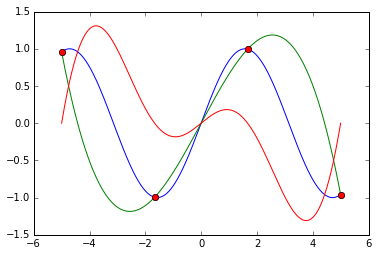

In [51]:
#f = lambda x: np.sin(2*np.pi*x)
f = lambda x: np.sin(x)

n = 3
q = np.linspace(-5,5,n+1)
Ln = lagrangian_interpolation_matrix(x,q)

_ = pl.plot(x, f(x))
_ = pl.plot(x, Ln.T.dot(f(q)))
_ = pl.plot(q, f(q),'ro')

err = f(x) - Ln.T.dot(f(q))
_ = pl.plot(x, err)

_ = pl.plot(q, f(q),'ro')

Error = l_infty(err)
print 'Error:', Error

We need a very simple function to evaluate the norm infinity of a function $||\cdot||_\infty$:

In [ ]:
def linfty_norm(fun):
    # Your function here
    return 

Now compute the following

$||f-p||_\infty = $ `error`

$||f^{n+1}||_\infty = $ `nth_der`

$w(x) =\prod_{i=0}^n (x-q_i), \quad ||w(x)||_\infty = $ `w`

3201918.98152


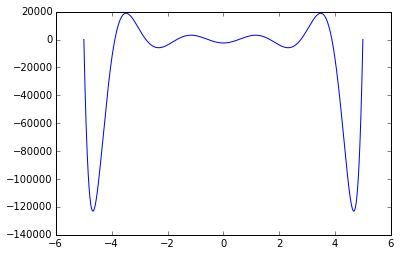

In [60]:
w = lambda x, q: np.product([ x - q[i] for i in range(len(q))], axis = 0)

q = np.linspace(-5,5,10)
_ = pl.plot(x, w(x,q))


Ln = lagrangian_interpolation_matrix(x,q)
Error = l_infty(f(x) - Ln.T.dot(f(q)))

fs = sym.sin(2*sym.pi*t)
fp = my_derivatives(fs, len(q))

nth_der = l_infty(fp(q))
w_infty = l_infty(w(x,q))

UpperEstimate = nth_der * w_infty/np.math.factorial(len(q))
print UpperEstimate

28798919.4233


ValueError: x and y must have same first dimension

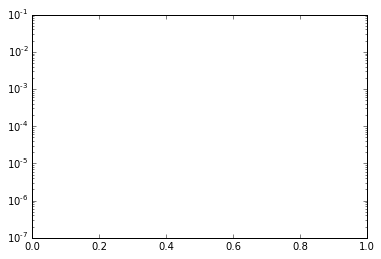

In [64]:
fs = sym.sin(2*sym.pi*t)

points = range(2,15)
UpperEstimate = []


for n in points:
    q = np.linspace(-5,5,n)



    Ln = lagrangian_interpolation_matrix(x,q)
    Error = l_infty(f(x) - Ln.T.dot(f(q)))


    fp = my_derivatives(fs, len(q))
    nth_der = l_infty(fp(q))
    
    w_infty = l_infty(w(x,q))

    UpperEstimate = nth_der * w_infty/np.math.factorial(len(q))
print UpperEstimate

_= pl.semilogy(points, UpperEstimate)

If I didn't mess the code this a good spot to play aroud with the function to be checked:

In [ ]:
# Test on one f

In [ ]:
# Make it a python function call